In [63]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import celerite
#from celerite import terms
from scipy.optimize import minimize

import pymc3 as pm
import theano.tensor as tt

import astropy.units as u

import pandas as pd
import exoplanet as xo

from astropy.io import fits
from astropy.table import Table

from flareTools import FINDflare, id_segments, EasyE
from flarePipeline import vetFlare

import matplotlib as mpl
mpl.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix',
                            'image.cmap': 'viridis'})

In [2]:
path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec1to13/'
#path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/gj1243/'
#path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec14to17/'

# Lots of flare detections towards the end
# Looks like the ones toward the beginning got missed
# This gets much better if we drop the CPA parameters to 3, 1, 3
f1 = 'tess2018206045859-s0001-0000000079403675-0120-s_lc.fits'

f2 = 'tess2019112060037-s0011-0000000121196226-0143-s_lc.fits'

f3 = 'tess2018206045859-s0001-0000000212262797-0120-s_lc.fits'

# Looks like a couple of strong flares are being missed?
# Its because I masked out this region of the LC
f4 = 'tess2018206045859-s0001-0000000266997586-0120-s_lc.fits'

# Lots of flares, why are some missed?
f5 = 'tess2018234235059-s0002-0000000102032397-0121-s_lc.fits'

# Looks like a big flare, but bad fit. Did the GP have trouble here?
f6 = 'tess2018349182459-s0006-0000000219423316-0126-s_lc.fits'

# Why did the GP fail here?
f6 = 'tess2019198215352-s0014-0000000273589987-0150-s_lc.fits'
f6 = 'tess2019226182529-s0015-0000000273589987-0151-s_lc.fits'

f6 = 'tess2018292075959-s0004-0000000168850387-0124-s_lc.fits'

f6 = 'tess2018319095959-s0005-0000000043472154-0125-s_lc.fits'
f6 = 'tess2018263035959-s0003-0000000207176480-0123-s_lc.fits'
#f6 = 'tess2018292075959-s0004-0000000088405858-0124-s_lc.fits'
#f6 = 'tess2019032160000-s0008-0000000312025443-0136-s_lc.fits'

#f6 = 'tess2018234235059-s0002-0000000332487879-0121-s_lc.fits'
#f6 = 'tess2019198215352-s0014-0000000273589987-0150-s_lc.fits' # GJ 1243

#f6 = 'tess2019198215352-s0014-0000000027778168-0150-s_lc.fits'

# Sec 14 and 15 fast rotators from Tyler's kepler-tess crossmatch

# < 0.5 d
#f6 = 'tess2019198215352-s0014-0000000184419029-0150-s_lc.fits' # Noise
#f6 = 'tess2019198215352-s0014-0000000416266231-0150-s_lc.fits'
#f6 = 'tess2019198215352-s0014-0000000027533798-0150-s_lc.fits' # Noise
#f6 = 'tess2019198215352-s0014-0000000164654552-0150-s_lc.fits' # Noise

# < 1 d
#f6 = 'tess2019198215352-s0014-0000000027843903-0150-s_lc.fits'
#f6 = 'tess2019198215352-s0014-0000000273589987-0150-s_lc.fits' # Flares! (GJ 1243)
#f6 = 'tess2019198215352-s0014-0000000351910775-0150-s_lc.fits' # Fast rotator, then noise after the mid-gap?
#f6 = 'tess2019198215352-s0014-0000000377782358-0150-s_lc.fits'
#f6 = 'tess2019198215352-s0014-0000000027843903-0150-s_lc.fits'

Text(0, 0.5, 'Flux [e-/s]')

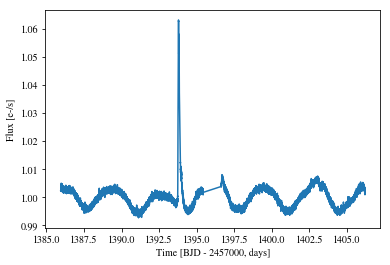

In [3]:
with fits.open(path+f6, mode='readonly') as hdulist:
    #print(hdulist[1].header)
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
    tess_quality = hdulist[1].data['QUALITY']
    
mask = (tess_quality == 0) & (~np.isnan(tess_bjds)) & (~np.isnan(pdcsap_fluxes))\
                  & (~np.isnan(pdcsap_flux_error))

time = tess_bjds[mask]
flux = pdcsap_fluxes[mask]
median = np.nanmedian(flux)
error = pdcsap_flux_error[mask]

plt.plot(time, flux/median)
plt.xlabel('Time [BJD - 2457000, days]')
plt.ylabel('Flux [e-/s]')
#plt.xlim(1624.8,1628)

In [4]:
acf = xo.autocorr_estimator(time, flux/median,
                        yerr=error/median,
                        min_period=0.1, max_period=27, max_peaks=2)

if len(acf['peaks']) > 0:
    acf_1dt = acf['peaks'][0]['period']
    mask = np.where((acf['autocorr'][0] == acf['peaks'][0]['period']))[0]
    acf_1pk = acf['autocorr'][1][mask][0]
    s_window = int(acf_1dt/np.fabs(np.nanmedian(np.diff(time))) / 6)
else:
    acf_1dt = (time[-1] - time[0])/2
    s_window = 128

In [5]:
acf_1dt, median, len(time)

(3.240232983331225, 43937.57, 13447)

In [57]:
n_samp = 4000
period_guess = acf_1dt

x = time
y = flux/median
yerr = error/median

x = x.astype(float)
y = y.astype(float)
yerr = yerr.astype(float)

x_ind_rand = np.random.choice(len(x), n_samp, replace=False)
x_ind = x_ind_rand[np.argsort(x[x_ind_rand])]

x_gp = x[x_ind]
y_gp = y[x_ind]
yerr_gp = yerr[x_ind]

# Do some aggressive sigma clipping
m = np.ones(len(x_gp), dtype=bool)
while True:
    mu = np.mean(y_gp[m])
    sig = np.std(y_gp[m])
    m0 = y_gp - mu < 3 * sig
    if np.all(m0 == m):
        break
    m = m0

x_gp = x_gp[m]
y_gp = y_gp[m]
yerr_gp = yerr_gp[m]

import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)

    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr)), sd=5.0)

    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
    logperiod = pm.Normal("logperiod", mu=np.log(period_guess), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = pm.Uniform("mix", lower=0, upper=1.0)

     # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))

    # Set up the Gaussian Process model
    kernel = xo.gp.terms.RotationTerm(
        log_amp=logamp,
        period=period,
        log_Q0=logQ0,
        log_deltaQ=logdeltaQ,
        mix=mix
    )
    gp = xo.gp.GP(kernel, x_gp, yerr_gp**2 + tt.exp(logs2), J=4)

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    pm.Potential("loglike", gp.log_likelihood(y_gp - mean))
    
    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)
    
    mu, var = xo.utils.eval_in_model(gp.predict(x_gp, return_var=True), map_soln)

optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp', 'logs2', 'mean']
message: Desired error not necessarily achieved due to precision loss.
logp: -2183556.1175751723 -> 23479.50474737772


In [58]:
mu, np.sqrt(var)

(array([0.00317318, 0.00318999, 0.00324742, ..., 0.00236757, 0.00222131,
        0.0021084 ]),
 array([0.00025283, 0.00023864, 0.00019725, ..., 0.00020282, 0.00023197,
        0.00025951]))

8.29393319133356


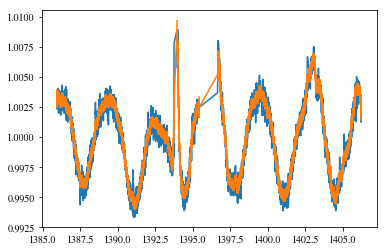

In [62]:
plt.plot(x_gp, y_gp)
plt.errorbar(x_gp, mu+1, yerr=np.sqrt(var)*3, zorder=3)
#plt.plot(x_gp, map_soln['pred']+1)
print(map_soln['period'])

In [167]:
def predict(x, y, yerr, m):
    with pm.Model() as model:
        # The mean flux of the time series
        #mean = pm.Normal("mean", mu=1.0, sd=10)

        # A jitter term describing excess white noise
        #logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr)), sd=5.0)

        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.var(y[m])), sd=5.0)
        logperiod = pm.Normal("logperiod", mu=np.log(period_guess), sd=5.0)
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = pm.Uniform("mix", lower=0.0, upper=1.0)

         # Track the period as a deterministic
        period = pm.Deterministic("period", tt.exp(logperiod))

        # Set up the Gaussian Process model
        kernel = xo.gp.terms.RotationTerm(
            log_amp=logamp,
            period=period,
            log_Q0=logQ0,
            log_deltaQ=logdeltaQ,
            mix=mix
        )
        gp = xo.gp.GP(kernel, x[m], yerr[m]**2, J=4)

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        pm.Potential("loglike", gp.log_likelihood(y[m] - 1))

        # Optimize to find the maximum a posteriori parameters
        map_soln = xo.optimize(start=model.test_point, verbose=False)

        mu, var = xo.utils.eval_in_model(gp.predict(x, return_var=True), map_soln)
        
    return mu, var

INFO (theano.gof.compilelock): Refreshing lock /astro/users/scw7/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-centos-7.8.2003-Core-x86_64-3.7.3-64/lock_dir/lock


optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp']
message: Desired error not necessarily achieved due to precision loss.
logp: 23158.415085736746 -> 23343.865941409847
[1.00283417 1.00286175 1.00291877 ... 1.00211062 1.00208783 1.00204367]
3349 3949
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp']
message: Optimization terminated successfully.
logp: 20385.546259093695 -> 20502.413545273444
[1.00271859 1.00273802 1.00277796 ... 1.00209036 1.00206976 1.00202952]
3075 3349
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp']
message: Desired error not necessarily achieved due to precision loss.
logp: 18869.458904914918 -> 18953.104260088538


INFO (theano.gof.compilelock): Refreshing lock /astro/users/scw7/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-centos-7.8.2003-Core-x86_64-3.7.3-64/lock_dir/lock


[1.00275248 1.00276448 1.00278901 ... 1.00206391 1.00204625 1.00201173]
2942 3075
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp']
message: Desired error not necessarily achieved due to precision loss.
logp: 18153.676218885623 -> 18196.30190380835
[1.00277038 1.00277872 1.00279569 ... 1.0021043  1.00208946 1.00206038]
2854 2942
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp']
message: Desired error not necessarily achieved due to precision loss.
logp: 17666.932113595743 -> 17692.52625944984
[1.00278805 1.0027951  1.00280936 ... 1.00213887 1.00212467 1.00209674]
2790 2854


INFO (theano.gof.compilelock): Refreshing lock /astro/users/scw7/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-centos-7.8.2003-Core-x86_64-3.7.3-64/lock_dir/lock


optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp']
message: Optimization terminated successfully.
logp: 17314.605062966642 -> 17329.64831361174
[1.00280714 1.00281283 1.0028243  ... 1.00217861 1.00216516 1.00213866]
2743 2790
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp']
message: Optimization terminated successfully.
logp: 17048.703443957264 -> 17059.753348654034
[1.00281987 1.00282363 1.00283116 ... 1.00221272 1.00219985 1.00217445]
2704 2743
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp']
message: Desired error not necessarily achieved due to precision loss.
logp: 16826.088422460885 -> 16836.199605178284


INFO (theano.gof.compilelock): Refreshing lock /astro/users/scw7/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-centos-7.8.2003-Core-x86_64-3.7.3-64/lock_dir/lock


[1.0028275  1.00283067 1.00283699 ... 1.00221484 1.00220296 1.00217949]
2674 2704
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp']
message: Desired error not necessarily achieved due to precision loss.
logp: 16654.438019734 -> 16664.997507825403
[1.00281666 1.00282047 1.00282788 ... 1.00220399 1.00219229 1.0021691 ]
2643 2674
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp']
message: Desired error not necessarily achieved due to precision loss.
logp: 16471.873914853313 -> 16483.46960646881
[1.00281955 1.00282305 1.00282984 ... 1.0022142  1.00220247 1.0021792 ]
2630 2643
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp']
message: Optimization terminated successfully.
logp: 16394.496515887877 -> 16406.705021233563


INFO (theano.gof.compilelock): Refreshing lock /astro/users/scw7/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-centos-7.8.2003-Core-x86_64-3.7.3-64/lock_dir/lock


[1.0028214  1.00282473 1.00283115 ... 1.00221927 1.00220753 1.00218423]
2619 2630
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp']
message: Desired error not necessarily achieved due to precision loss.
logp: 16328.559349312398 -> 16341.326341541562
[1.00282281 1.00282599 1.00283211 ... 1.0022235  1.00221175 1.00218839]
2608 2619
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp']
message: Optimization terminated successfully.
logp: 16263.645504632947 -> 16277.189744514577
[1.00282368 1.00282676 1.00283266 ... 1.00222782 1.00221608 1.00219272]
2599 2608
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp']
message: Desired error not necessarily achieved due to precision loss.
logp: 16209.554616938427 -> 16223.411447389202


INFO (theano.gof.compilelock): Refreshing lock /astro/users/scw7/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-centos-7.8.2003-Core-x86_64-3.7.3-64/lock_dir/lock


[1.00282472 1.0028277  1.00283342 ... 1.00223236 1.00222079 1.00219778]
2592 2599
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp']
message: Desired error not necessarily achieved due to precision loss.
logp: 16167.645106016274 -> 16181.796389245581
[1.00282509 1.00282802 1.00283366 ... 1.00223385 1.00222228 1.00219927]
2584 2592
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp']
message: Optimization terminated successfully.
logp: 16119.631869006893 -> 16134.007162969487
[1.00282511 1.00282803 1.00283363 ... 1.00223529 1.00222397 1.00220144]
2579 2584
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp']
message: Optimization terminated successfully.
logp: 16089.653438453479 -> 16104.187792216793


INFO (theano.gof.compilelock): Refreshing lock /astro/users/scw7/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-centos-7.8.2003-Core-x86_64-3.7.3-64/lock_dir/lock


[1.00282547 1.00282835 1.00283388 ... 1.00224049 1.00222924 1.00220685]
2577 2579
Done
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp']
message: Optimization terminated successfully.
logp: 16077.768009093204 -> 16092.406426618976


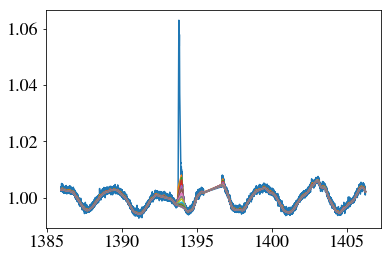

In [169]:
num_iter = 20
n_samp = 4000
max_tries = 1
try_count = 0
period_guess = acf_1dt

x = time
y = flux/median
yerr = error/median

x = x.astype(float)
y = y.astype(float)
yerr = yerr.astype(float)

plt.plot(x,y)

while try_count < max_tries:
    try:
        # Randomly select n points from the light curve for the GP fit
        x_ind_rand = np.random.choice(len(x), n_samp, replace=False)
        x_ind = x_ind_rand[np.argsort(x[x_ind_rand])]

        x_gp = x[x_ind]
        y_gp = y[x_ind]
        yerr_gp = yerr[x_ind]

        # Do some aggressive sigma clipping
        m = np.ones(len(x_gp), dtype=bool)
        while True:
            mu = np.mean(y_gp[m])
            sig = np.std(y_gp[m])
            m0 = y_gp - mu < 3 * sig
            if np.all(m0 == m):
                break
            m = m0

        x_gp = x_gp[m]
        y_gp = y_gp[m]
        yerr_gp = yerr_gp[m]

        # Find the best fit kernel parameters. We want to try to ignore the flares
        # when we do the fit. To do this, we will repeatedly find the best fit
        # solution to the kernel model, calculate the covariance matrix, predict
        # the flux and then mask out points based on how far they deviate from
        # the model. After a few passes, this should cause the model to fit mostly
        # to periodic features.
        m = np.ones(len(x_gp), dtype=bool)
        for i in range(num_iter):
            n_pts_prev = np.sum(m)
            mu, var = predict(x_gp, y_gp, yerr_gp, m)
            mu += 1
            print(mu)
            sig = np.sqrt(var + yerr_gp**2)

            m0 = y_gp - mu < sig
            plt.plot(x_gp, mu)
            m[m==1] = m0[m==1]
            n_pts = np.sum(m)
            print(n_pts, n_pts_prev)
            if n_pts <= 10:
                raise ValueError('GP iteration threw out too many points')
                break
            if (n_pts_prev - n_pts) <= 3:
                print('Done')
                break
        try_count = max_tries
    except RuntimeError:
        print('Need to try again')
        try_count += 1

mu, var = predict(x_gp, y_gp, yerr_gp, m)
sig = np.sqrt(var + yerr_gp**2)

In [182]:
map_soln

{'mean': array(0.9996771),
 'logs2': array(-22.38944901),
 'logamp': array(-12.2495528),
 'logperiod': array(1.21275378),
 'logQ0': array(-1.1629382),
 'logdeltaQ': array(6.59285125),
 'mix_interval__': array(-0.71798983),
 'mix': array(0.32783579),
 'period': array(3.36273213)}

In [172]:
mu_int = np.interp(time, x_gp, mu)
var_int = np.interp(time, x_gp, var)
std_int = np.sqrt(var_int)
error_full = np.sqrt((error/median)**2 + var_int)

(0.99, 1.01)

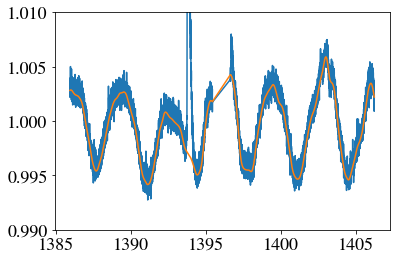

In [173]:
plt.plot(time, flux/median)
plt.plot(time, mu_int+1)
#plt.fill_between(time, mu_int - 3*error_full + 1, mu_int + 3*error_full + 1)
#plt.xlim(1431.4, 1431.7)
plt.ylim(0.99, 1.01)

In [64]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', -11.772128359015824),
             ('kernel:terms[0]:log_omega0', 0.5450475496658583),
             ('kernel:terms[1]:log_S0', -25.0),
             ('kernel:terms[1]:log_Q', 2.9959573667896993),
             ('kernel:terms[1]:log_omega0', 2.5669272952349593)])

In [67]:
w0 = 10**gp.get_parameter_vector()[1]
per = 2*np.pi/w0
per

1.791151490077008

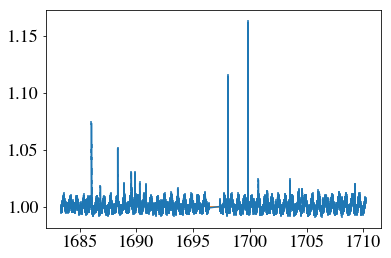

In [48]:
plt.errorbar(time, flux/median, yerr=error_full)
plt.plot(time, mu_int)
#plt.xlim(1431.4, 1431.7)

In [49]:
from scipy.optimize import minimize, curve_fit
import traceback
def fitFlare(x, y, yerr, tstart, tstop, skew_fac=10):
    mask = (x > tstart) & (x < tstop)
    mu0 = (tstart + tstop)/2
    sig0 = (tstop - tstart)/2
    A0 = np.max(y)*100
    skew = 0

    try:
        # Fit a gaussian to the segment
        print(sig0, A0)
        popt1, pcov1 = curve_fit(fh.gaussian, x[mask], y[mask], p0=(mu0, sig0, A0), \
                                 bounds=((tstart, -np.inf, -np.inf), (tstop, np.inf, np.inf)), sigma=yerr[mask])
        y_model = fh.gaussian(x[mask], popt1[0], popt1[1], popt1[2])
        chi1 = fh.redChiSq(y_model, y[mask], yerr[mask], len(y[mask]) - 3)
        print(popt1)

        # Fit the Davenport 2014 flare model to the segment
        popt2, pcov2 = curve_fit(fh.aflare1, x[mask], y[mask], p0=(mu0, sig0, A0), \
                                 bounds=((tstart, 0, 0), (tstop, np.inf, np.inf)), sigma=yerr[mask])
        #popt2[0] = 1431.5369029375856 - 0.0026
        #popt2[1] = 0.004358571227427768*0.5
        #popt2[2] = 0.1948384536203991*3.5
        y_model = fh.aflare1(x[mask], popt2[0], popt2[1], popt2[2])
        chi2 = fh.redChiSq(y_model, y[mask], yerr[mask], len(y[mask]) - 3)
        print(popt2)

        # If the flare model fit worked, calculate the skew by centering on the peak of the aflare model
        # Use a window scaled to the FWHM of the flare model for integration
        mu = popt2[0] #np.trapz(x[mask]*A*y[mask], x[mask])
        f_hwhm = popt2[1]/2
        t1_skew, t2_skew = mu - skew_fac*f_hwhm, mu + skew_fac*f_hwhm
        skew_mask = (x > t1_skew) & (x < t2_skew)

        # Measure the skew by treating time = x and flux = p(x). Calculate the
        # third moment of p(x)
        A = 1/np.trapz(y[skew_mask], x[skew_mask])
        var = np.trapz((x[skew_mask] - mu)**2*A*y[skew_mask], x[skew_mask])
        stddev = np.sqrt(np.fabs(var))
        skew = np.trapz((x[skew_mask] - mu)**3*A*y[skew_mask], x[skew_mask])/stddev**3
    except:
        traceback.print_exc()
        empty = np.zeros(3)
        return empty, empty, -1, empty, empty, -1, 0, 0

    n_pts = len(x[mask])
    n_pts_true = np.floor(((tstop-tstart)*u.d).to(u.min).value/2)
    coverage = n_pts/n_pts_true

    return popt1, np.sqrt(pcov1.diagonal()), chi1, popt2, np.sqrt(pcov2.diagonal()), chi2, skew, coverage

0.011111247935332358 1.0112345568250691
[1.68571690e+03 2.89909887e-03 6.07120245e-05]
[1.68571550e+03 5.66975858e-03 1.00490614e-02]
1685.714516589542 1685.7200722135096 1685.7154971861291 0.7125606816977191 1.2076070956508291 1.0012038
0.011111247935332358 1.1251890330429504
[1.68573588e+03 4.85496989e-03 9.38315971e-05]
[1.68573361e+03 6.69088528e-03 1.14741223e-02]
1685.733961273662 1685.7395168976298 1685.733614502696 0.5821760777270936 1.4958102941708227 1.0021399
0.03611155299586244 7.02638494289245
[1.68603211e+03 4.16992856e-03 5.16009437e-04]
[1.68602891e+03 4.25766237e-03 8.16907478e-02]
1686.0284093353332 1686.0464651118311 1686.0289143615537 12.240600486727182 23.24294118451307 1.0107464
0.011111244673884357 2.105835244700849
[1.68681719e+03 1.84429641e-03 7.81158049e-05]
[1.68681620e+03 2.28084927e-03 2.74441727e-02]
1686.8159189046944 1686.8214745270313 1686.8161978068308 0.9114379549625019 8.558200934988767 1.0021595
0.01666686165935971 4.545375963529663
[1.68834263e+03

/astro/users/scw7/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


1704.6132804359515 1704.6563360616303 1704.6212267600808 1.4784766957576398 2.145165310098894 1.0019103
0.008333346544532105 1.0112345568250691
[1.70466031e+03 3.98782848e-03 6.74236255e-05]
[1.70465922e+03 8.52133206e-03 7.46096484e-03]
1704.6591138440442 1704.6632805173165 1704.6592211245227 0.9510860076098356 0.4207426102189519 1.0034127
0.01388890857970182 1.1518600668559142
[1.70694032e+03 4.23536378e-03 7.69903466e-05]
[1.70693756e+03 3.00097457e-03 1.94758271e-02]
1706.9368949989919 1706.9438394532817 1706.937557363266 0.5956847734514499 2.596003637962285 0.9988306
0.016666695416461152 1.183573546592076
[1.70814718e+03 7.72402077e-03 1.59031750e-04]
[1.70814374e+03 1.32237681e-02 1.10214076e-02]
1708.1410635235154 1708.1493968712236 1708.1437392825326 0.9860336967139387 1.9783835967774057 1.000851
0.01666670938629977 1.162233538677948
[1.70920682e+03 3.22856399e-03 7.38244160e-05]
[1.70920506e+03 4.47266331e-03 1.22599287e-02]
1709.2035657183653 1709.2118990730585 1709.205063329

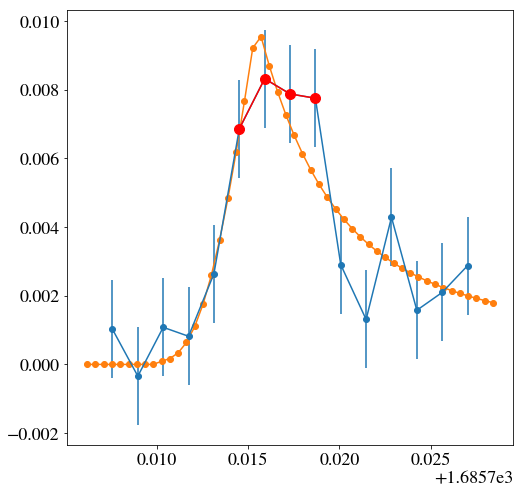

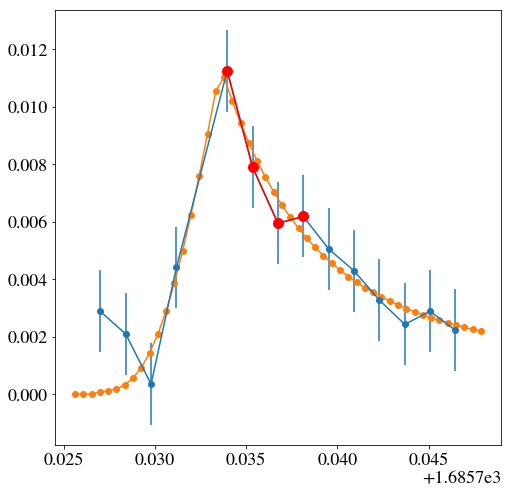

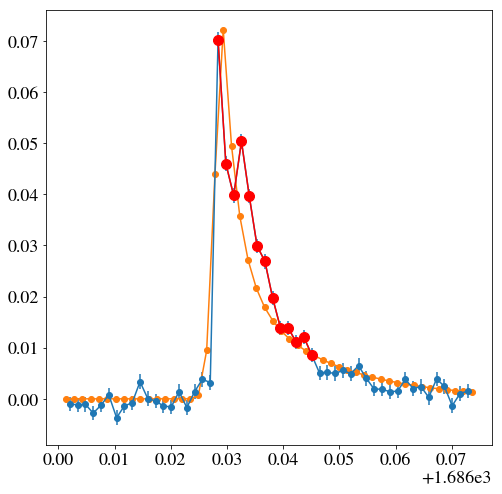

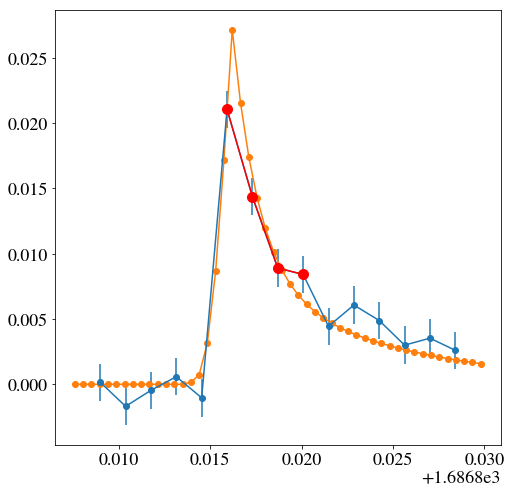

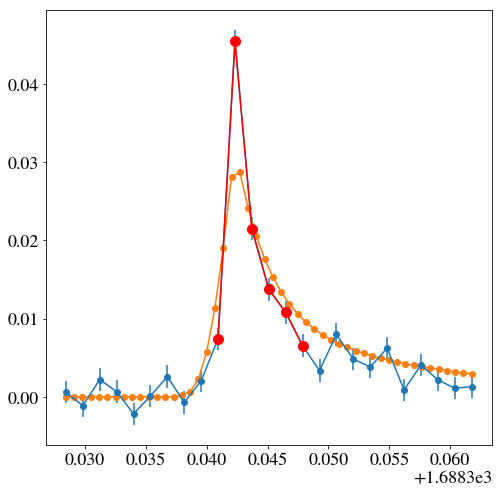

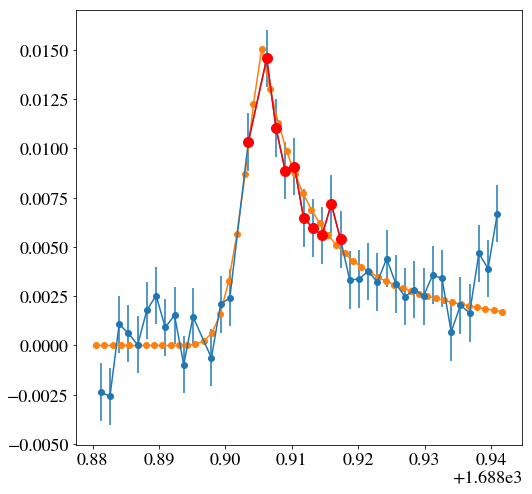

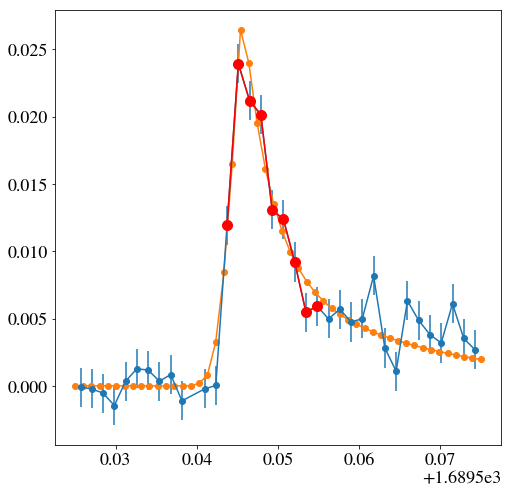

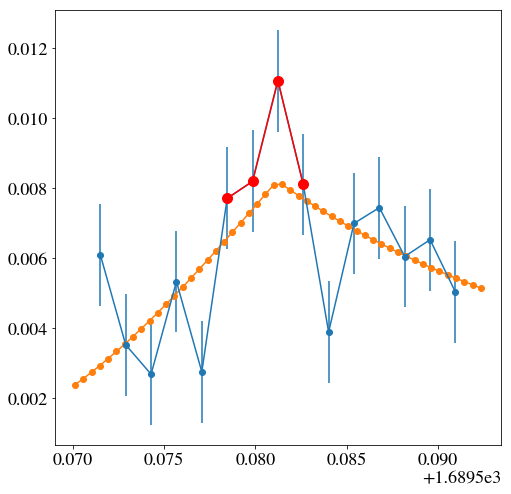

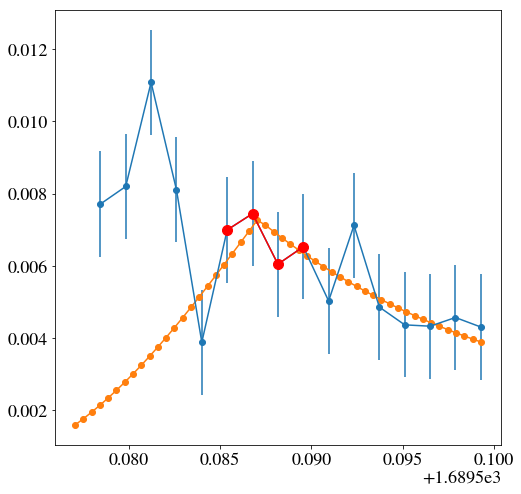

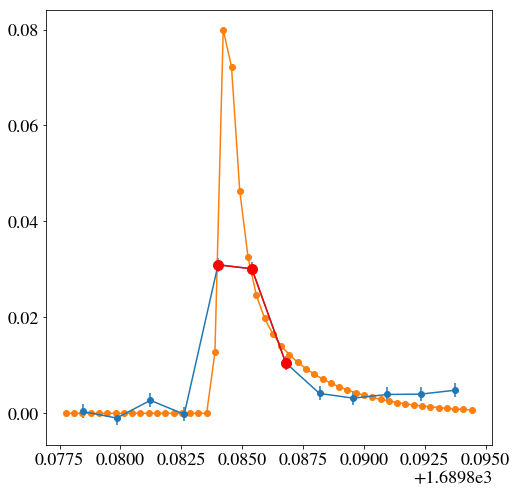

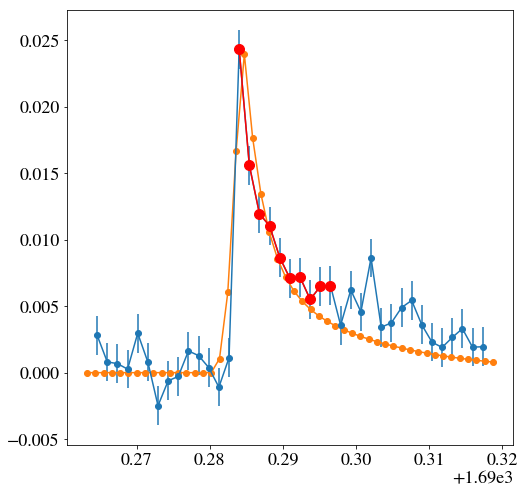

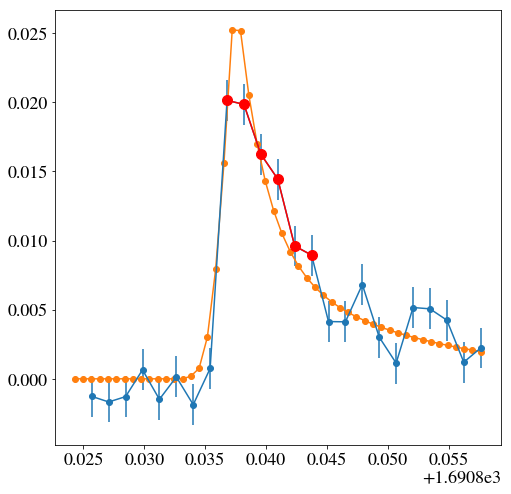

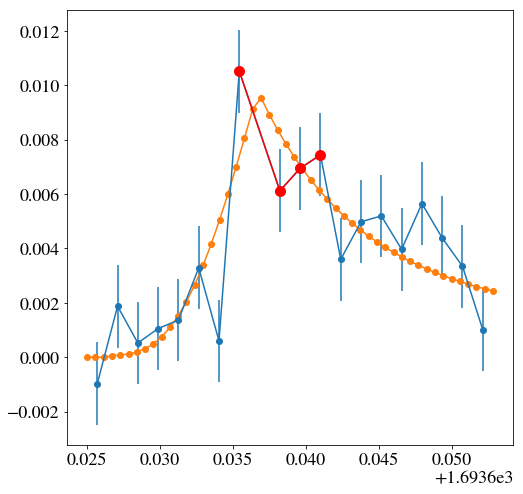

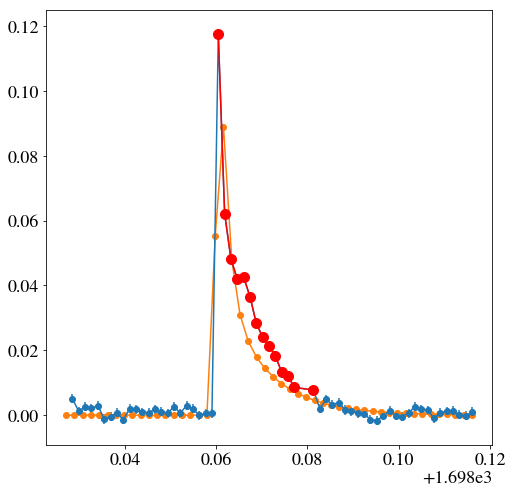

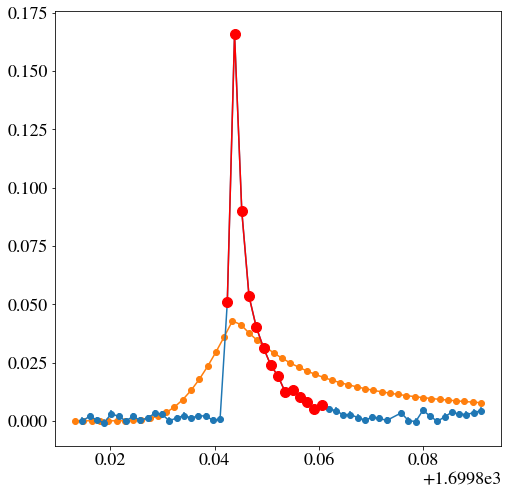

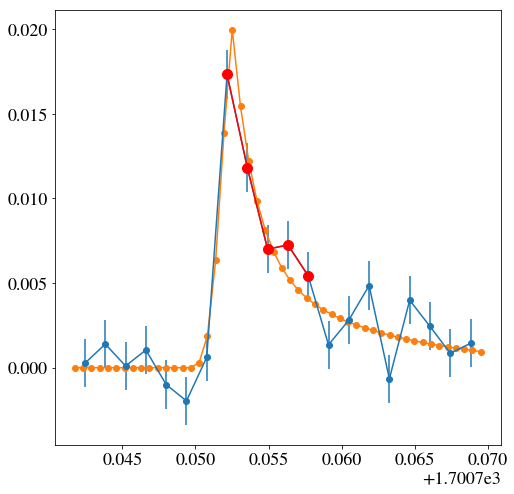

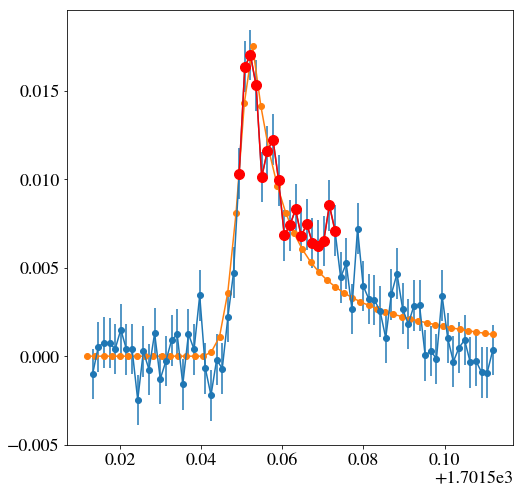

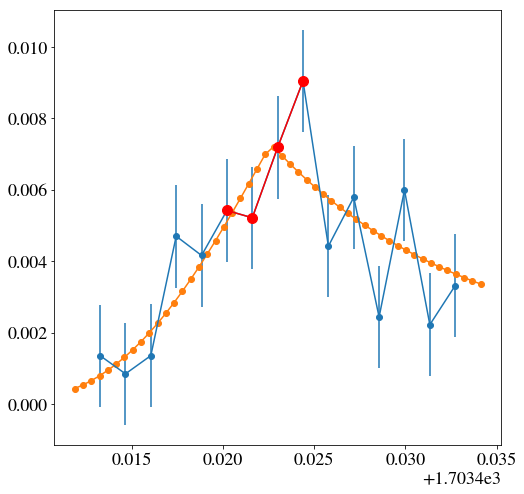

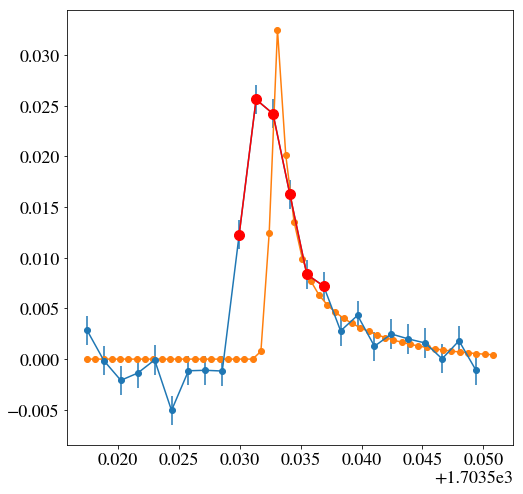

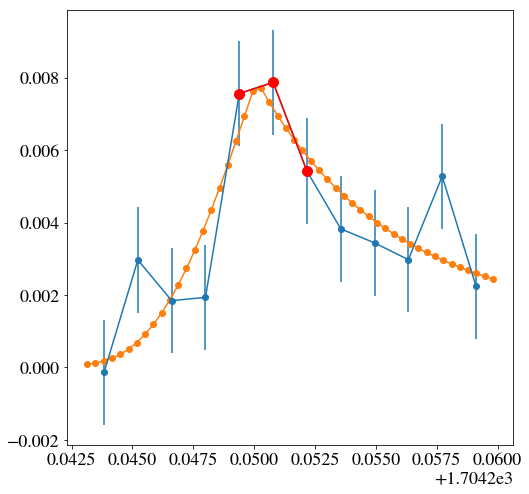

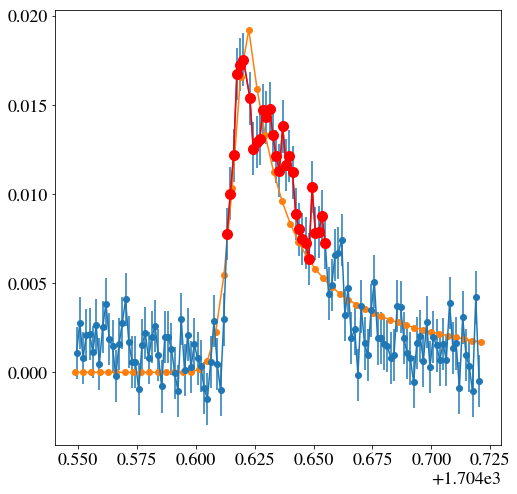

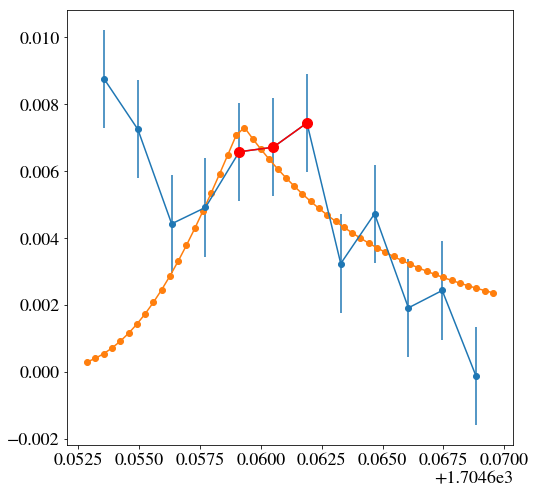

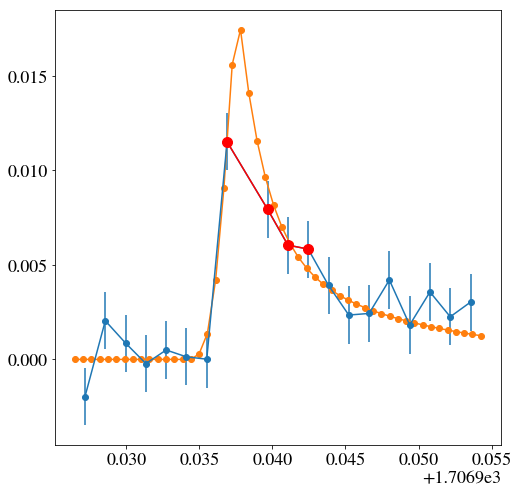

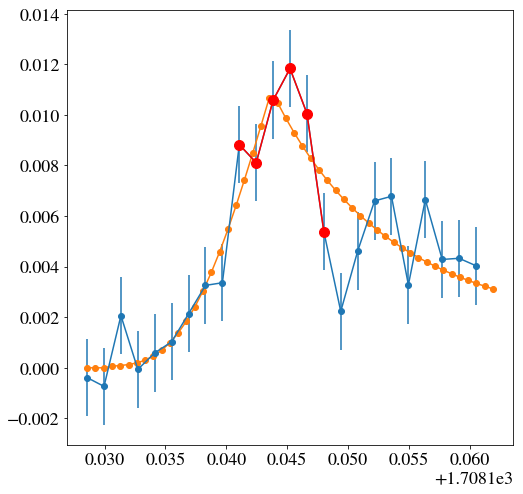

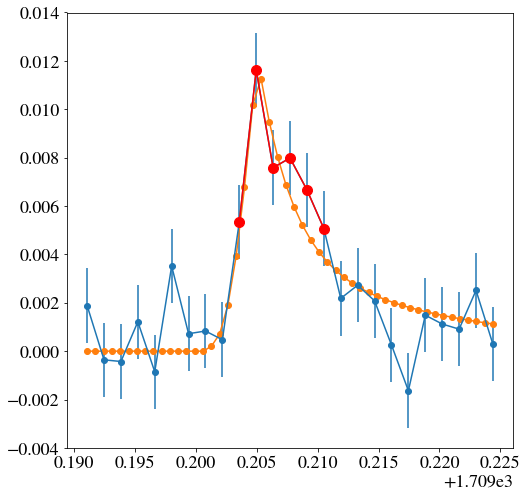

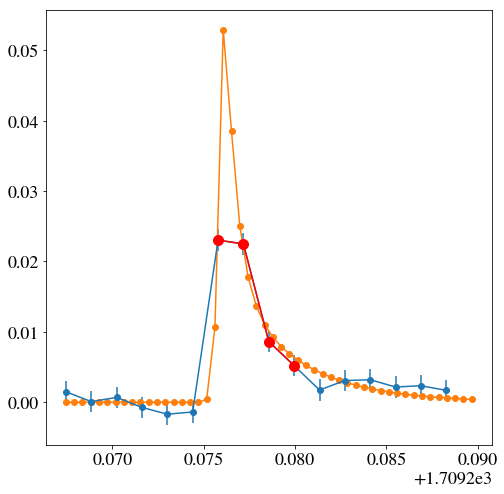

In [50]:
#from flareFind import fitFlare
import flareHelpers as fh

x = time
y = flux/median - mu_int
yerr = error_full

# Search for flares in the smoothed light curve using change point analysis
FL = FINDflare(y, yerr, avg_std=True, std_window=s_window, N1=3, N2=1, N3=3)
for j in range(len(FL[0])):
    s1, s2 = FL[0][j], FL[1][j]+1
    tstart, tstop = x[s1], x[s2]
    #if tstart < 1431 or tstart > 1432:
        #continue
    dx_fac  = 3
    dx = tstop - tstart
    x1 = tstart - dx*dx_fac/2
    x2 = tstop + dx*dx_fac/2
    mask = (x > x1) & (x < x2)
    
    med = np.nanmean(flux[mask])/median

    # Mask out other flare detections when fitting models
    other_mask = np.ones(len(x), dtype=bool)
    for i in range(len(FL[0])):
        s1other, s2other = FL[0][i], FL[1][i]+1
        if i == j:
            continue
        other_mask[s1other:s2other] = 0

    popt1, pstd1, g_chisq, popt2, pstd2, f_chisq, skew, cover = \
        fitFlare(x[other_mask], y[other_mask], yerr[other_mask], x1, x2)

    mu, std, g_amp = popt1[0], popt1[1], popt1[2]
    mu_err, std_err, g_amp_err = pstd1[0], pstd1[1], pstd1[2]

    tpeak, fwhm, f_amp = popt2[0], popt2[1], popt2[2]
    tpeak_err, fwhm_err, f_amp_err = pstd2[0], pstd2[1], pstd2[2]
    
    fig, axes = plt.subplots(figsize=(8,8))
    axes.plot(x[s1:s2], y[s1:s2], marker='o', color='r', markersize=10, zorder=5)
    #axes.plot(x[~other_mask], y[~other_mask], marker='o', color='orange', markersize=20)
    axes.errorbar(time[mask], flux[mask]/median - mu_int[mask], error[mask]/median, marker='o')
    
    xmodel = np.linspace(x1, x2)
    ymodel = fh.aflare1(xmodel, tpeak, fwhm, f_amp)
    print(tstart, tstop, tpeak, f_chisq, g_chisq, med)
    axes.plot(xmodel, ymodel, marker='o')
    
    ymodel = fh.gaussian(xmodel, mu, std, g_amp)
    #axes.plot(xmodel, ymodel, marker='o')

1.0022154

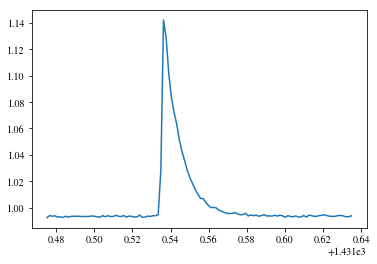

In [25]:
#plt.plot(time, flux)
plt.plot(time[mask], flux[mask]/median)
np.nanmean(flux[mask])/median

In [ ]:
tstart_vals = np.zeros(len(FL[0]))
fig, axes = plt.subplots(figsize=(16,8))
axes.plot(time, flux/median)
axes.plot(time, mu_int)
for j in range(len(FL[0])):
    tstart_vals[j]= x[s1]
    s1, s2 = FL[0][j], FL[1][j]+1
    dx_fac  = 3
    tstart, tstop = x[s1], x[s2]
    dx = tstop - tstart
    x1 = tstart - dx*dx_fac/2
    x2 = tstop + dx*dx_fac/2
    mask = (x > x1) & (x < x2)
    axes.plot(x[s1:s2], flux[s1:s2]/median, marker='o', color='r', markersize=2, zorder=5)
    
    mean_flux = np.mean(flux[mask]/median)
    #print(tstart)
    if mean_flux < 1:
        axes.plot(x[s1:s2], flux[s1:s2]/median, marker='o', color='b', markersize=2, zorder=5)

In [ ]:
np.std(np.diff(np.sort(tstart_vals)))

In [ ]:
tpeak, fwhm, f_amp, f_chisq, g_chisq

In [ ]:
xdata = time[mask]
ydata = flux[mask]/median - mu_int[mask]
yerr = error[mask]/median
plt.plot(xdata, ydata)
len(xdata), len(ydata), len(yerr)

In [ ]:
import emcee, corner
walkers, steps, burn_steps = 50, 5000, 2000

In [ ]:
def log_prior1(theta):
    tpeak, fwhm, f_amp = theta
    if tpeak < 0 or fwhm < 0 or f_amp < 0:
        return -np.inf
    return 0

def log_likelihood1(theta, x, y, yerr):
    tpeak, fwhm, f_amp = theta
    y_model = fh.aflare1(x, tpeak, fwhm, f_amp)
    return -0.5 * np.sum(np.log(2 * np.pi * (yerr) ** 2) + (y - y_model) ** 2 / (2*(yerr)**2))

def log_posterior1(theta, x, y, yerr):
    return log_prior1(theta) + log_likelihood1(theta, x, y, yerr)

guess = [tpeak, fwhm, f_amp]
ndim = len(guess)
nwalkers, nsteps, nburn = walkers, steps, burn_steps
pos = [guess + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior1, args=(xdata, ydata, yerr))
%time sampler.run_mcmc(pos, nsteps)
print("done")

samples1 = sampler.chain[:, nburn:, :].reshape(-1, ndim)

best_fit1 = np.mean(samples1, axis=0)
fig = corner.corner(samples1, labels=['tpeak', 'fwhm', 'f_amp'],
                      truths=guess)

In [ ]:
def log_prior2(theta):
    mu, sigma, A = theta
    if mu < 0 or sigma < 0 or A < 0 or mu > xdata[-1] or mu < xdata[0]:
        return -np.inf
    return 0

def log_likelihood2(theta, x, y, yerr):
    mu, sigma, A = theta
    y_model = fh.gaussian(x, mu, sigma, A)
    return -0.5 * np.sum(np.log(2 * np.pi * (yerr) ** 2) + (y - y_model) ** 2 / (2*(yerr)**2))

def log_posterior2(theta, x, y, yerr):
    return log_prior2(theta) + log_likelihood2(theta, x, y, yerr)

guess = [tpeak, fwhm, f_amp]
ndim = len(guess)
nwalkers, nsteps, nburn = walkers, steps, burn_steps
pos = [guess + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior2, args=(xdata, ydata, yerr))
%time sampler.run_mcmc(pos, nsteps)
print("done")

samples2 = sampler.chain[:, nburn:, :].reshape(-1, ndim)

best_fit2 = np.mean(samples2, axis=0)
fig = corner.corner(samples2, labels=['mu', 'sigma', 'A'],
                      truths=guess)

In [ ]:
best_fit1, best_fit2

In [ ]:
l_max1 = log_posterior1((best_fit1[0], best_fit1[1], best_fit1[2]), xdata, ydata, yerr)
l_max2 = log_posterior2((best_fit2[0], best_fit2[1], best_fit2[2]), xdata, ydata, yerr)
print(l_max1, l_max2)
bic1 = np.log(len(xdata))*2. - 2.*l_max1
bic2 = np.log(len(xdata))*4. - 2.*l_max2
print(bic1, bic2)

In [ ]:
ymodel = fh.aflare1(xdata, best_fit1[0], best_fit1[1], best_fit1[2])
plt.plot(xdata, ydata)
plt.plot(xdata, ymodel)
chi2_f = fh.redChiSq(ymodel, ydata, yerr, len(ydata) - 3)

ymodel = fh.gaussian(xdata, best_fit2[0], best_fit2[1], best_fit2[2])
plt.plot(xdata, ymodel)
chi2_g = fh.redChiSq(ymodel, ydata, yerr, len(ydata) - 3)
chi2_f, chi2_g